## Barren plateau analysis

Variance is the average squared deviation of the list elements from the average value.

Next: Get COBYLA optimization trajectory

-6 Sept: New method of calculating delta averaged for plot, instead of reporting multiple delta shots per parameter iteration

-2 Sept: Added detailed E(theta) plot and set average E(theta) from measurements for one-to-one

-31 August for small delta taken from uniform [-0.1, 0.1] range

In [2]:
import numpy as np 
from scipy.optimize import minimize, BFGS
import time
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Gate
from qiskit import Aer, transpile, assemble
from qiskit.quantum_info.operators import Operator, Pauli    # for operator
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit import Aer, transpile, assemble      # to run quantum simulation
from qiskit.visualization import plot_histogram

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

backend = Aer.get_backend("qasm_simulator")
np.set_printoptions(precision=7)    # numpy print precision
np.set_printoptions(suppress=True)  # suppress scientific notation

# define constants
QUBIT_COUNT = 4
DEPTH = 1                     # depth of main ansatz
PARAM_COUNT = QUBIT_COUNT*(2*DEPTH+2)   
NUM_SHOTS = 3000              # number of shots per quantum simulation
print('Setup done')

Setup done


In [3]:
# Making Hamiltonian (from Miceli and McGuigan paper)
n = 2**QUBIT_COUNT    # for code clarity, in matrix preparation
lattice = []
leftmost = (1-n)/2    # consider lattice 15 June
Xpos = []     # Position matrix

for i in range(n):
    lattice.append(leftmost + i)
    # for position matrix    
    Xpos_row = []
    for j in range(n):
        Xpos_row.append(0)
    Xpos_row[i] = (leftmost + i)*np.sqrt(2*np.pi/n)
    Xpos.append(Xpos_row)
    #print("Xpos_row is: ",Xpos_row)
    
print("lattice is: ", lattice)
Xpos = np.array(Xpos)
#print("Xpos is: ")
#print(Xpos)

F = np.zeros([n,n], dtype=complex)  # zero matrix 
for j in range(n):
    for k in range(n):
        x = 1/np.sqrt(n)*np.e**(2*np.pi*(1j/n)*lattice[j]*lattice[k])
        F[j][k] = x

print("Check if Fourier operator calculated is unitary (F_dagger*F=I)")
F_dagger = np.transpose(np.conjugate(F))
#print(F.dot(F_dagger))
FourierOperator = Operator(F)

P = (F_dagger.dot(Xpos.dot(F)))
Hamiltonian = P.dot(P)/2  # flat potential well model here
Hamiltonian2 = P.dot(P)/2 + Xpos.dot(Xpos)/2    # with harmonic

#print("Momentum Operator (P) :")
#print(P) 
#print("Hamiltonian (H) :")
#print(Hamiltonian)

H_dagger2 = np.transpose(np.conjugate(Hamiltonian2))
#print("H2 dagger minus H2 (should be zero)")    # check Hermitian by taking conjugate, H=H^t
#print(H_dagger2-Hamiltonian2)



lattice is:  [-7.5, -6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
Check if Fourier operator calculated is unitary (F_dagger*F=I)


In [4]:
# get eigenvalue in numpy
from numpy import linalg as LA
print("The eigenvalues are: ", LA.eigvals(Hamiltonian))

min_eigenvalue = np.real(min(LA.eigvals(Hamiltonian)))
print("Lowest eigenvalue is ", min_eigenvalue)

The eigenvalues are:  [11.0446617-0.j 11.0446617+0.j  5.9395736-0.j  8.2957681-0.j
  8.2957681+0.j  5.9395736+0.j  3.9760782+0.j  3.9760782+0.j
  2.4052819+0.j  2.4052819+0.j  1.2271846-0.j  1.2271846-0.j
  0.0490874+0.j  0.0490874+0.j  0.4417865-0.j  0.4417865+0.j]
Lowest eigenvalue is  0.049087385212339844


### Position and momentum ansatzes

===== New get_ansatz_pos circuit =====


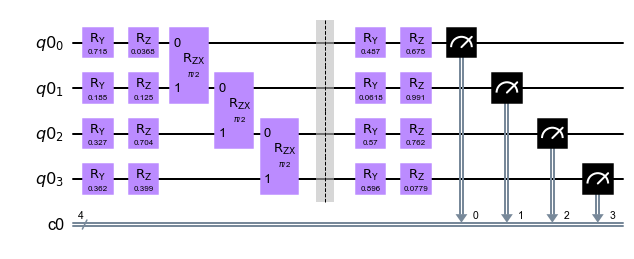

In [5]:
def get_ansatz_pos(params):    
    """
    Edited for subspace VQE 
    New ansatz builder function using DEPTH setting
    params is a list, input_line is an integer (0 to 7)
    This ansatz measures in the X basis (position space)
    """
    
    qr = QuantumRegister(QUBIT_COUNT)        
    cr = ClassicalRegister(QUBIT_COUNT)
    qc = QuantumCircuit(qr, cr)
    
    
    for layer in range(DEPTH):    
        # pre-entangling section
        qc.ry(params[2*layer], qr[0])    
        qc.rz(params[2*layer + 1], qr[0])
        qc.ry(params[2*layer + 2*DEPTH + 2], qr[1])   # second wire
        qc.rz(params[2*layer + 2*DEPTH + 3], qr[1])    
        if QUBIT_COUNT >= 3:
            qc.ry(params[2*layer + 4*DEPTH + 4], qr[2])   # third wire
            qc.rz(params[2*layer + 4*DEPTH + 5], qr[2])    
        if QUBIT_COUNT >= 4:
            qc.ry(params[2*layer + 6*DEPTH + 6], qr[3])   # fourth wire     
            qc.rz(params[2*layer + 6*DEPTH + 7], qr[3])

        # entangling
        qc.rzx(np.pi/2, qr[0], qr[1])
        if QUBIT_COUNT >= 3:
            qc.rzx(np.pi/2, qr[1], qr[2])
        if QUBIT_COUNT >= 4:
            qc.rzx(np.pi/2, qr[2], qr[3])
        qc.barrier()    
    
    qc.ry(params[2*DEPTH], qr[0])   # first wire 
    qc.rz(params[2*DEPTH+1], qr[0])
    qc.ry(params[4*DEPTH+2], qr[1])   # second wire
    qc.rz(params[4*DEPTH+3], qr[1])
    if QUBIT_COUNT >= 3:
        qc.ry(params[6*DEPTH+4], qr[2])  # third wire
        qc.rz(params[6*DEPTH+5], qr[2])    
    if QUBIT_COUNT >= 4:
        qc.ry(params[8*DEPTH+6], qr[3])   # fourth wire      
        qc.rz(params[8*DEPTH+7], qr[3])
    
    for i in range(QUBIT_COUNT):
        qc.measure(qr[i], cr[i])

    return qc
    
wild_params = np.random.rand(PARAM_COUNT)
print("===== New get_ansatz_pos circuit =====")
my_circuit = get_ansatz_pos(wild_params)
my_circuit.draw(output='mpl')

===== Sample get_ansatz_ham circuit for momentum space measurement =====


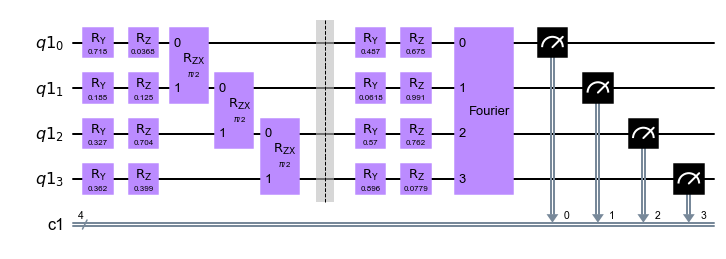

In [6]:
def get_ansatz_ham(params):    
    """
    Basic function (no line input)
    new ansatz builder function using four angles per qubit wire
    params is a list, input_line is an integer (0 to 7)
    This ansatz measures in the P basis (momentum space) with Fourier transform block
    """   

    qr = QuantumRegister(QUBIT_COUNT)        
    cr = ClassicalRegister(QUBIT_COUNT)
    qc = QuantumCircuit(qr, cr)
    
    for layer in range(DEPTH):    
        # pre-entangling section
        qc.ry(params[2*layer], qr[0])    
        qc.rz(params[2*layer + 1], qr[0])
        qc.ry(params[2*layer + 2*DEPTH + 2], qr[1])   # second wire
        qc.rz(params[2*layer + 2*DEPTH + 3], qr[1])    
        if QUBIT_COUNT >= 3:
            qc.ry(params[2*layer + 4*DEPTH + 4], qr[2])   # third wire
            qc.rz(params[2*layer + 4*DEPTH + 5], qr[2])    
        if QUBIT_COUNT >= 4:
            qc.ry(params[2*layer + 6*DEPTH + 6], qr[3])   # fourth wire     
            qc.rz(params[2*layer + 6*DEPTH + 7], qr[3])

        # entangling
        qc.rzx(np.pi/2, qr[0], qr[1])
        if QUBIT_COUNT >= 3:
            qc.rzx(np.pi/2, qr[1], qr[2])
        if QUBIT_COUNT >= 4:
            qc.rzx(np.pi/2, qr[2], qr[3])
        qc.barrier()    
    
    qc.ry(params[2*DEPTH], qr[0])   # first wire 
    qc.rz(params[2*DEPTH+1], qr[0])
    qc.ry(params[4*DEPTH+2], qr[1])   # second wire
    qc.rz(params[4*DEPTH+3], qr[1])
    if QUBIT_COUNT >= 3:
        qc.ry(params[6*DEPTH+4], qr[2])  # third wire
        qc.rz(params[6*DEPTH+5], qr[2])    
    if QUBIT_COUNT >= 4:
        qc.ry(params[8*DEPTH+6], qr[3])   # fourth wire      
        qc.rz(params[8*DEPTH+7], qr[3])

    qubit_list = []
    for i in range(QUBIT_COUNT):
        qubit_list.append(i)
    
    qc.unitary(FourierOperator,qubit_list,label="Fourier")
    for j in range(QUBIT_COUNT):
        qc.measure(qr[j], cr[j])

    return qc

print("===== Sample get_ansatz_ham circuit for momentum space measurement =====")
my_circuit = get_ansatz_ham(wild_params)
my_circuit.draw(output='mpl')

===== Single qubit test ansatz =====


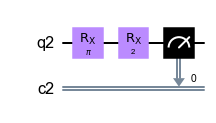

In [7]:
# one qubit simple ansatz
def get_quantum_circuit_one(param):    
    """
    1 qubit --> optimize as pi to go from 1 to 0
    """   
    
    qr = QuantumRegister(1)        
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)
    
    qc.rx(np.pi, qr[0])   # default input from 0 to 1
    qc.rx(param, qr[0])
    qc.measure(qr[0], cr[0])
    return qc

print("===== Single qubit test ansatz =====")
my_circuit = get_quantum_circuit_one(2)
my_circuit.draw(output='mpl')

### 3. Support Functions

In [8]:
# result automation
allresults = []   # list
def get_output(dec_number):
    # decimal number is input, output as binary
    # with zeros in front --> 1 becomes 001 when QUBIT_COUNT=3
    # outputs binary as string
    bin_number = str(bin(dec_number).replace("0b", ""))
    while len(bin_number) < QUBIT_COUNT:
        bin_number = "0" + bin_number
    return bin_number

for count in range(n):    # where n is 2**QUBIT_COUNT
    allresults.append(get_output(count))
print(allresults)

def get_probability_distribution_new(counts):
    # return array of probability    21st May
    output_distr = []    # initialize empty array
    for result in allresults:    # automate this list too
        if counts.get(result) != None:
            output_distr.append(counts.get(result)/NUM_SHOTS)
        else:
            output_distr.append(0)
        #print(result)       
    return output_distr

def get_probability_distribution_one(counts):
    # return array of probability    
    output_distr = []    # initialize empty array
    for result in ['0','1']:    
        if counts.get(result) != None:
            output_distr.append(counts.get(result)/NUM_SHOTS)
        else:
            output_distr.append(0)
        #print(result)       
    return output_distr

costArray = []    # to assign cost for each point on lattice
for point in lattice:
    costArray.append(2*np.pi/(2**QUBIT_COUNT)*point**2/2)
#print(costArray)   # pre-factor; not just lattice squared

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


### 4. Implementation function (need to change from objective function in Closed Loop codes)

### Single qubit case

Time to run code segment:
NUM_SPACING = 50; NUM_SAMPLES = 20 --> 12 seconds
NUM_SPACING = 500; NUM_SAMPLES = 20 with expectation_measured --> 120 seconds

In [9]:
def measure_results_one(param):
    """
    Measure expectation value of simple ansatz populated by param
    """
    cost = 0
    qc = get_quantum_circuit_one(param)
    t_qc = transpile(qc, backend)
    qobj = assemble(t_qc, shots=NUM_SHOTS)     # run circuit NUM_SHOTS times
    result = backend.run(qobj).result()
    output_distr = get_probability_distribution_one(result.get_counts(qc))
    cost = output_distr[1]*1    # keep '1' value only
    print(float(param))
    return cost

def measure_results_one_printcost(param):
    """
    Measure expectation value of simple ansatz populated by param
    """
    cost = 0
    qc = get_quantum_circuit_one(param)
    t_qc = transpile(qc, backend)
    qobj = assemble(t_qc, shots=NUM_SHOTS)     # run circuit NUM_SHOTS times
    result = backend.run(qobj).result()
    output_distr = get_probability_distribution_one(result.get_counts(qc))
    cost = output_distr[1]*1    # keep '1' value only
    print(cost)
    return cost

print(measure_results_one(1))

sensitivity_results_one = []    # name has _one
param_tested = []
expectation_measured = []

start_time = time.time()
NUM_SPACING = 20    # Number of spacings for theta (x axis)
NUM_SAMPLES = 10    # Number of repeat samples of slope

for theta in range(NUM_SPACING):
    param = theta/NUM_SPACING*3.14  # span 0 to pi
    original_result_one = measure_results_one(param)  
    expectation_measured.append(original_result_one)
    delta_sum = 0
    for repeat in range(NUM_SAMPLES): # test each parameter sensitivity 
        test_param = param    # clone to float
        variation = np.random.rand(1)*0.2-0.1    # Uniform [-0.1,0.1] distribution
        test_param += float(variation)
        new_result_one = measure_results_one(test_param)
        delta = float((new_result_one-original_result_one)/(variation))
        delta_sum += delta
    
    sensitivity_results_one.append(delta_sum/NUM_SAMPLES)
    param_tested.append(param)    # to plot later
        
print("Calculations done")
print("--- %s seconds ---" % round((time.time() - start_time),1))

variance_result_one = np.var(sensitivity_results_one)
print("Set variance is "+str(variance_result_one))
print("Standard deviation is "+str(np.sqrt(variance_result_one)))

1.0
0.7706666666666667
0.0
-0.052594145089401724
-0.0029964419145379895
0.06763982329223392
0.062161040506750254
-0.02344265496417823
0.08488928525741057
-0.010771702049415091
0.008440080701251268
-0.034864803716583334
-0.08060949659898974
0.15700000000000003
0.1472914186279749
0.09312280678808364
0.2516845822747198
0.23018202044188982
0.21079677670703942
0.18031207107879477
0.23714934710155466
0.15846550682236474
0.06024888992835106
0.15275639523162604
0.31400000000000006
0.36881986603994604
0.26038373398617326
0.30991775060753757
0.2833821181425056
0.23876490098741596
0.3887389189582683
0.27116497548334645
0.2787860473932891
0.3422047781652414
0.33257516487663297
0.471
0.4161382066327519
0.37437886101182904
0.5501265117623382
0.46125406770297134
0.39689767346543925
0.5347451247347031
0.5678794115110362
0.5444263493632394
0.5164749225147096
0.5418273859154902
0.6280000000000001
0.6412030356922525
0.7099936988920528
0.6878671103255977
0.540310518353967
0.7011234802323087
0.717255917078

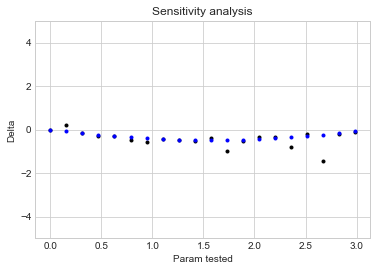

In [10]:
# single qubit case
y = sensitivity_results_one
x = param_tested
fit_gradient = []

plt.plot(x, y, '.', color='black')
plt.title('Sensitivity analysis')
plt.xlabel("Param tested")
plt.ylabel("Delta")

for angle in param_tested:
    fit_gradient.append(-0.5*np.sin(angle))

plt.plot(x, fit_gradient, '.', color='blue')
   
plt.ylim(-5,5)
plt.show()



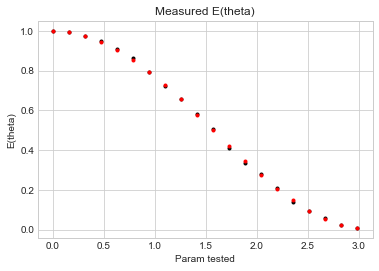

In [11]:
# single qubit case
y = expectation_measured
x = param_tested
fit_cos = []

plt.plot(x, y, '.', color='black')
plt.title('Measured E(theta)')
plt.xlabel("Param tested")
plt.ylabel("E(theta)")


for angle in param_tested:
    fit_cos.append(0.5+0.5*np.cos(angle))

plt.plot(x, fit_cos, '.', color='red')
plt.plot

#plt.ylim(-10,10)
plt.show()

In [12]:
for value in range(len(expectation_measured)):
    print(expectation_measured[value])
    # expectation y axis results for plotting

1.0
0.993
0.9736666666666667
0.9476666666666667
0.9063333333333333
0.861
0.7916666666666666
0.7226666666666667
0.6563333333333333
0.581
0.5066666666666667
0.4116666666666667
0.33466666666666667
0.2803333333333333
0.207
0.13733333333333334
0.09566666666666666
0.056
0.024666666666666667
0.006


In [13]:
for value in range(len(param_tested)):
    print(param_tested[value])
    # param_tested x axis results for plotting

0.0
0.15700000000000003
0.31400000000000006
0.471
0.6280000000000001
0.785
0.942
1.099
1.2560000000000002
1.413
1.57
1.7270000000000003
1.884
2.0410000000000004
2.198
2.355
2.5120000000000005
2.669
2.826
2.983


### Multi-angle entangled ansatz

In [14]:
def measure_results(params):
    """
    Measure expectation value of ansatz, populated by params
    """
    cost = 0
     
    qc_Ham = get_ansatz_ham(params)
        
    # === Hamiltonian part (P measurement) ===
    t_qc_Ham = transpile(qc_Ham, backend)
    qobj_Ham = assemble(t_qc_Ham, shots=NUM_SHOTS)     # run circuit NUM_SHOTS times
    result_Ham = backend.run(qobj_Ham).result()
    output_distr_Ham = get_probability_distribution_new(result_Ham.get_counts(qc_Ham))
    
    for i in range(n):
        cost += costArray[i]*output_distr_Ham[i]   # see costArray def above
    
    #print(cost)
    return cost

In [15]:
sensitivity_results = []
start_time = time.time()

NUM_SEED = 2    # Number of spacings for theta (x axis)
NUM_SAMPLES = 2    # Number of repeat samples of slope 

# For reference, three layers (PARAM_COUNT=32), NUM_SEED=2 and NUM_SAMPLES=10 took 23 seconds to run

for seed in range(NUM_SEED):
# loop across seed
    np.random.seed(seed)
    wild_params = np.random.rand(PARAM_COUNT)
    original_result = measure_results(wild_params)

    for count in range(PARAM_COUNT):
    # loop across PARAM_COUNT
        delta_averaged = 0
        for repeat in range(NUM_SAMPLES):
        # test each parameter sensitivity 
            test_params = wild_params   # clone
            variation = np.random.rand(1)*0.2-0.1    # Uniform [-0.1,0.1] distribution
            test_params[count] += variation
            new_result = measure_results(test_params)
            delta_averaged += float((new_result-original_result)/(variation))
            
        delta_averaged = delta_averaged/NUM_SAMPLES
        sensitivity_results.append(delta_averaged)
            #print(delta)
    print(seed)
print("Calculations done")
print("--- %s seconds ---" % round((time.time() - start_time),1))


0
1
Calculations done
--- 1.5 seconds ---


Layers: 1
Set variance is 87.39997764487873
Standard deviation is 9.34879551840122


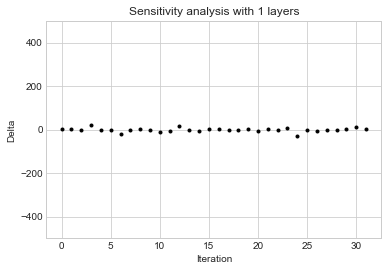

In [16]:
np.random.rand(1)*2-1   # rand outputs random number between 0 and 1
                        # maps to uniform [-1,1] distribution
#print(sensitivity_results)    
variance_result = np.var(sensitivity_results)
print("Layers: "+str(DEPTH))
print("Set variance is "+str(variance_result))
print("Standard deviation is "+str(np.sqrt(variance_result)))

y = sensitivity_results
plt.plot(y, '.', color='black')
plt.title('Sensitivity analysis with '+str(DEPTH)+' layers')
plt.xlabel("Iteration")
plt.ylabel("Delta")
plt.ylim(-500,500)
plt.show()

### Convergence trajectory for single gate circuit

In [22]:
from qiskit.aqua.components.optimizers import COBYLA, SPSA    # for optimization

optimizer = SPSA(maxiter=100, save_steps=1, last_avg=1, c0=0.62, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False)

#SPSA
start_time = time.time()
SPSAsol = optimizer.optimize(num_vars=1, objective_function=measure_results_one, initial_point=[0])
print("--- %s seconds ---" % round((time.time() - start_time),4))

print("SPSAsol:", SPSAsol[0])
print("SPSA returns objective function value of", measure_results_one(SPSAsol[0]))

0.1
-0.1
0.1
-0.1
0.1
-0.1
-0.1
0.1
0.1
-0.1
-0.1
0.1
-0.1
0.1
0.1
-0.1
0.1
-0.1
-0.1
0.1
0.1
-0.1
0.1
-0.1
-0.1
0.1
-0.1
0.1
-0.1
0.1
0.1
-0.1
0.1
-0.1
0.1
-0.1
-0.1
0.1
-0.1
0.1
0.1
-0.1
1.2120245092510613
1.398501806538428
46.742205094576505
46.56321015670515
65.93518993575574
65.76132102373774
69.67362319295279
69.8436173621109
80.65110334388615
80.81799580509801
62.82016356882122
62.655849369984956
60.277093794549195
60.43920681852625
45.925129417359095
46.08532535627695
62.364456895740645
62.20595662964455
53.970493261524965
54.127475072346286
45.489388442134235
45.33378016661212
62.715764576289665
62.56140921554448
59.76630777488619
59.613103436361556
59.765775844991246
59.613635366256496
59.78218264547943
59.93333463831106
57.45052248464314
57.60075178843747
65.9657643234954
65.81639979486634
66.53259273872726
66.68114384212268
60.112275132188635
59.96449162598399
56.812434243706086
56.95949129276648
60.5516634499954
60.69803116902159
53.577149289680065
53.43143723432206
52.301

In [23]:
optimizer = COBYLA(maxiter=2000, tol=0.00001)

start_time = time.time()
COBYLAsol = optimizer.optimize(num_vars=1, objective_function=measure_results_one, initial_point=[0])
print("--- %s seconds ---" % round((time.time() - start_time),4))

print("COBYLAsol:", COBYLAsol[0])
print("COBYLA returns objective function value of", measure_results_one(COBYLAsol[0]))

0.0
1.0
2.0
3.0
4.0
3.5
2.75
3.125
3.25
3.1875
3.09375
3.140625
3.126953125
3.125244140625
3.12451171875
3.125244140625
3.125030517578125
3.125005
--- 0.1646 seconds ---
COBYLAsol: [3.125]
3.125
COBYLA returns objective function value of 0


In [24]:
sol = minimize(measure_results_one, 0, method = 'Nelder-Mead')

print("--- %s seconds ---" % round((time.time() - start_time),4))
print("sol.x:", sol.x)
print("BFGS returns objective function value of", measure_results_one(sol.x))

0.0
0.00025
-0.00025
0.000125
0.000125
-0.000125
6.25e-05
6.25e-05
--- 6.8321 seconds ---
sol.x: [0.]
0.0
BFGS returns objective function value of 1.0
